In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats, signal
import matplotlib.pyplot as plt

In [2]:
scale = 1e5

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*(np.power(C*scale, p)/scale)*(1-np.power(((C*scale)/(K*scale)), a))

In [4]:
def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [5]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")
data["DATE"] = pd.to_datetime(data["DATE"])

In [6]:
cases = data.groupby("DATE")["CASES"].sum().to_frame()
cases["index"] = (cases.index - cases.index[0])//pd.Timedelta("1d")
cases["cumsum"] = cases["CASES"].cumsum()
cases = cases.reset_index().rename(columns={"CASES": "daily", "DATE": "date"}).set_index("date")
cases["cs_mv14d"] = cases["cumsum"].rolling(14).mean().shift(-7)
cases["d_mv14d"] = cases["cs_mv14d"].diff()
cases["cs_savgol"] = signal.savgol_filter(cases["cumsum"], 31, 7)
cases["d_savgol"] = cases["cs_savgol"].diff()
cases.to_csv("covid.csv", index=False)
cases.sample(10)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol
date,,,,,,,
2020-11-01,2661,245,454124,4.584841e+05,10954.214286,4.612167e+05,10892.940615
2020-08-06,769,158,73874,7.392229e+04,596.428571,7.366438e+04,634.280396
2021-10-21,6905,599,1308190,1.312265e+06,6112.071429,1.305954e+06,6144.967047
2021-04-25,1138,420,973392,9.764300e+05,3228.928571,9.754165e+05,3107.469723
2022-01-01,4070,671,2129869,2.156552e+06,16554.785714,2.136780e+06,16254.299426
2020-10-24,11552,237,349796,3.552259e+05,14799.142857,3.479281e+05,16406.554073
2022-02-03,25864,704,3307015,3.294695e+06,24372.928571,3.300229e+06,23348.974771
2020-11-12,6467,256,532778,5.325080e+05,4451.642857,5.320816e+05,4385.672362
2020-11-04,9213,248,489261,4.857230e+05,7972.714286,4.880847e+05,7680.895859


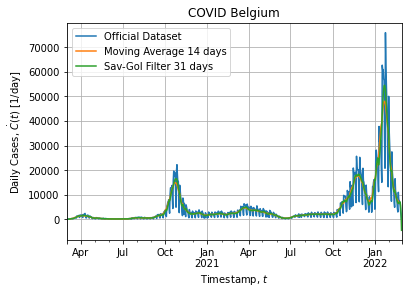

In [7]:
axe = cases["daily"].plot(label="Official Dataset")
cases["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

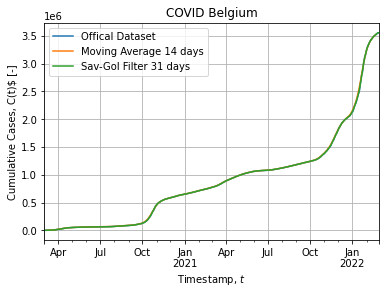

In [8]:
axe = cases["cumsum"].plot(label="Offical Dataset")
cases["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.set_yscale("linear")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, C(t)$ [-]")
axe.grid()

In [9]:
t0 = "2021-12-21"
t1 = "2022-02-21"

In [10]:
peak = cases.loc[(cases.index >= t0) & (cases.index < t1), :]
for k in ["index", "cumsum", "cs_mv14d", "cs_savgol"]:
    peak[k + "_origin"] = peak[k] - peak[k][0]
peak.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin,cs_savgol_origin
date,,,,,,,,,,,
2022-01-19,60893,689,2677749,2.703118e+06,45920.857143,2.664647e+06,50265.680238,29,650278,6.717338e+05,6.382598e+05
2022-02-09,16773,710,3412738,3.407891e+06,14867.928571,3.410405e+06,14276.402926,50,1385267,1.376506e+06,1.384018e+06
2022-01-10,37756,680,2332469,2.357764e+06,27829.142857,2.333002e+06,23218.059805,20,304998,3.263800e+05,3.066144e+05
2022-02-15,11525,716,3478697,3.478367e+06,9762.000000,3.479025e+06,10304.123395,56,1451226,1.446983e+06,1.452638e+06
2022-02-05,12471,706,3341871,3.338086e+06,21106.785714,3.340822e+06,19589.309697,46,1314400,1.306701e+06,1.314435e+06


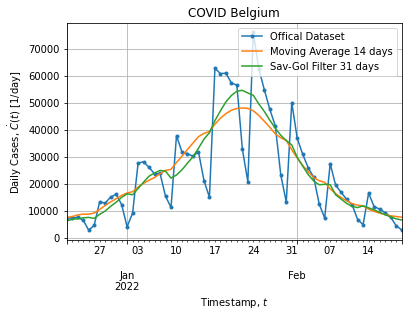

In [11]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset")
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

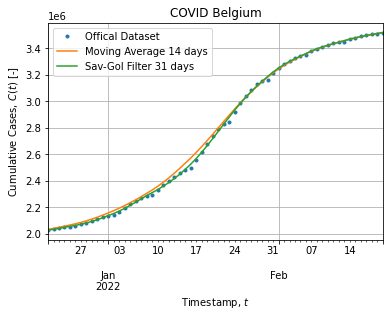

In [12]:
axe = peak["cumsum"].plot(marker=".", linestyle="none", label="Offical Dataset")
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.grid()

In [13]:
def resample(frame):
    sample = frame.copy()
    # Reindex:
    sample = frame.set_index("index_origin")
    index = np.arange(sample.index.min(), sample.index.max() + 0.001, 0.25)
    sample = sample.reindex(index).interpolate().reset_index()
    # Resample:
    sample = sample.sample(frac=1.0, replace=True).sort_index()
    # Deduplicate + Counts:
    count = sample.groupby(sample.index)["index"].count()
    count.name = "count"
    sample = sample.drop_duplicates().merge(count, left_index=True, right_index=True)
    sample = sample.sort_index()
    sample["sigma"] = np.sqrt(1/sample["count"])
    return sample
r = resample(peak)
#r.set_index("index_origin")["cs_mv14d_origin"].plot()

In [14]:
np.random.seed(123456789)

In [49]:
params = pd.read_csv("bootstrap_raw_x4_200.csv")

In [50]:
params.sample(5)

,C,r,p,K,a
90,0.184085,2.245921,0.754663,14.870616,2.272303
45,0.159837,2.388111,0.751448,14.867680,2.224980
6,0.174687,2.089146,0.762075,14.887860,2.147535
69,0.187969,1.418766,0.793882,14.902322,2.002301
105,0.120573,5.890049,0.677794,14.888582,2.641810


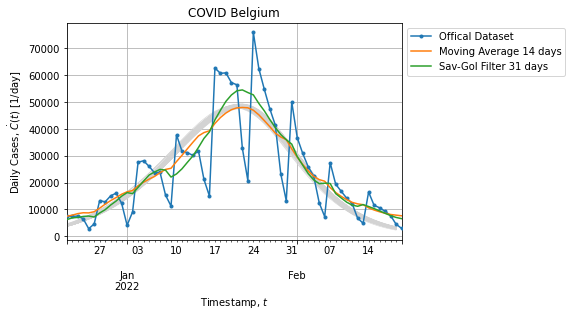

In [51]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale
    axe.plot(peak.index[:-1], np.diff(c), color="lightgrey", linewidth=0.6)
#c = GRM(peak["index"], *popt)
#axe.plot(peak.index[:-1], np.diff(c), "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

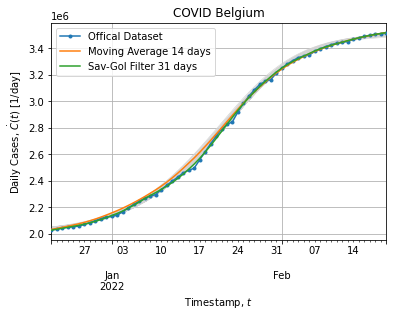

In [52]:
fig, axe = plt.subplots()
peak["cumsum"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale + peak["cumsum"][0]
    axe.plot(peak.index, c, color="lightgrey", linewidth=0.6)
#c = GRM(peak["index"], *popt) + peak["cumsum"][0]
#axe.plot(peak.index, c, "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

In [53]:
sparams = params.copy()

In [54]:
for k in ["C", "K"]:
    sparams[k] *= scale

In [55]:
sstats = sparams.describe()
print(sstats.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>C</th>
      <th>r</th>
      <th>p</th>
      <th>K</th>
      <th>a</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>200.000000</td>
      <td>200.000000</td>
      <td>200.000000</td>
      <td>2.000000e+02</td>
      <td>200.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>17311.803293</td>
      <td>2.238137</td>
      <td>0.760107</td>
      <td>1.489341e+06</td>
      <td>2.144541</td>
    </tr>
    <tr>
      <th>std</th>
      <td>1903.272072</td>
      <td>0.650363</td>
      <td>0.023034</td>
      <td>4.431465e+03</td>
      <td>0.141343</td>
    </tr>
    <tr>
      <th>min</th>
      <td>12057.333017</td>
      <td>0.947984</td>
      <td>0.677794</td>
      <td>1.467269e+06</td>
      <td>1.735155</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>15893.622810</td>
      <td>1.809203</td>
      <td>0.745926</td>
      <td>1

In [56]:
RSD = sstats.loc["std",:]/sstats.loc["mean",:]
print(RSD.to_frame().rename(columns={0: "RSD"}).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>RSD</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>C</th>
      <td>0.109941</td>
    </tr>
    <tr>
      <th>r</th>
      <td>0.290582</td>
    </tr>
    <tr>
      <th>p</th>
      <td>0.030304</td>
    </tr>
    <tr>
      <th>K</th>
      <td>0.002975</td>
    </tr>
    <tr>
      <th>a</th>
      <td>0.065908</td>
    </tr>
  </tbody>
</table>


In [57]:
quantiles = sparams.quantile([0.05, 0.95])

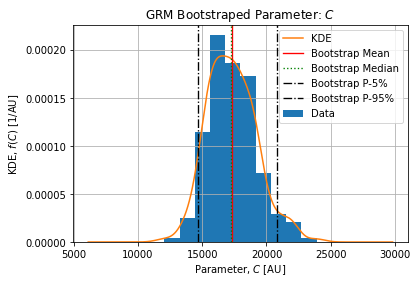

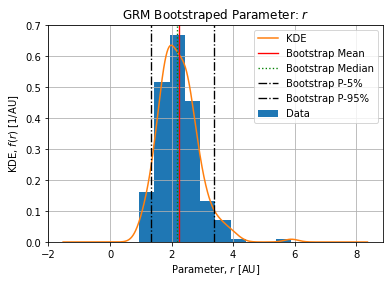

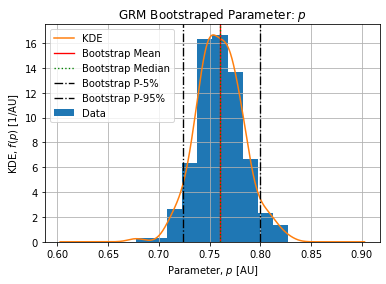

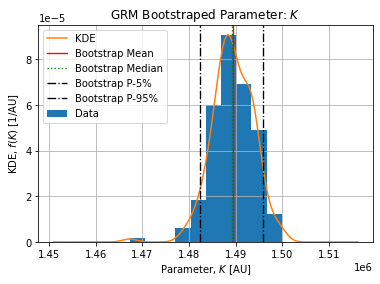

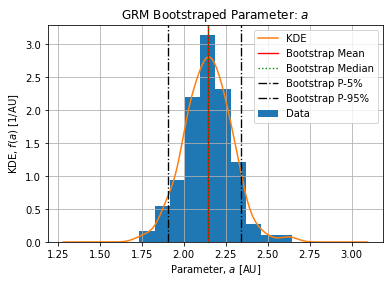

In [58]:
for i, k in enumerate(params):
    fig, axe = plt.subplots()
    sparams[k].plot(kind="hist", ax=axe, label="Data", density=1)
    sparams[k].plot(kind="kde", ax=axe, label="KDE")
    axe.axvline(sstats.loc["mean", k], linestyle="-", color="red", linewidth=1.35, label="Bootstrap Mean")
    axe.axvline(sstats.loc["50%", k], linestyle=":", color="green", linewidth=1.35, label="Bootstrap Median")
    axe.axvline(quantiles.loc[0.05, k], linestyle="-.", color="black", linewidth=1.35, label="Bootstrap P-5%")
    axe.axvline(quantiles.loc[0.95, k], linestyle="-.", color="black", linewidth=1.35, label="Bootstrap P-95%")
    #axe.axvline(popt[i], linestyle="-.", color="red", linewidth=1.35, label="Single Fit")
    axe.legend()
    axe.set_title(r"GRM Bootstraped Parameter: $%s$" % k)
    axe.set_xlabel(r"Parameter, $%s$ [AU]" % k)
    axe.set_ylabel(r"KDE, $f(%s)$ [1/AU]" % k)
    axe.grid()

Text(0, 0.5, 'Standardized Distributions')

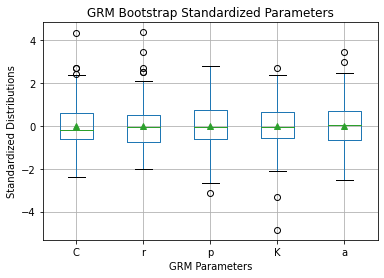

In [25]:
zP = (sparams - sstats.loc["mean",:])/sstats.loc["std",:]
axe = zP.boxplot(showmeans=True)
axe.set_title("GRM Bootstrap Standardized Parameters")
axe.set_xlabel("GRM Parameters")
axe.set_ylabel("Standardized Distributions")

In [32]:
tests = []
for k in sstats:
    p = stats.norm.fit(zP[k])
    t = stats.ks_1samp(zP[k], stats.norm().cdf)
    tests.append({
        "parameter": k,
        "loc": p[0], "scale": p[1],
        "ks": t.statistic, "p-value": t.pvalue
    })
tests = pd.DataFrame(tests)

In [35]:
#print(
tests.set_index("parameter")#.to_html())

,loc,scale,ks,p-value
parameter,,,,
C,1.296740e-15,0.997497,0.080350,0.143109
r,8.659740e-17,0.997497,0.065699,0.338981
p,-1.110223e-15,0.997497,0.039186,0.906524
K,2.784439e-15,0.997497,0.047484,0.739512
a,-5.817569e-16,0.997497,0.030478,0.989722
